In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import locale
import functions
from scipy.stats import ttest_ind, chi2_contingency
from tabulate import tabulate  
from pathlib import Path





## Функции

In [59]:
# Установка глобальных параметров для визуализаций
def configure_visualizations():
    """
    Устанавливает глобальные настройки для визуализаций.
    Это включает стилистику графиков и размеры шрифтов.
    """
    sns.set(style="whitegrid", palette="muted")
    plt.rcParams.update({
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "figure.titlesize": 18
    })

In [60]:
# Загрузка и предобработка данных
def load_and_preprocess_data(file_path):
    """
    Загружает данные из указанного файла и выполняет предобработку:
    - Преобразует даты
    - Удаляет дубликаты
    - Добавляет возрастные группы, года и месяцы
    :param file_path: Путь к Excel-файлу с данными
    :return: Предобработанный DataFrame
    """
    data = pd.read_excel(file_path)
    data['service_date'] = pd.to_datetime(data['service_date'])
    data.drop_duplicates(inplace=True)
    
    # Добавление новых столбцов
    data['year'] = data['service_date'].dt.year
    data['month'] = data['service_date'].dt.to_period("M")
    
    bins = [0, 18, 35, 50, 65, 80, 100]
    labels = ["0-18", "19-35", "36-50", "51-65", "66-80", "81-100"]
    data["age_group"] = pd.cut(data["age_for_service_date"], bins=bins, labels=labels)
    
    return data

In [61]:
# Расчёт ключевых метрик
def calculate_metrics(data):
    """
    Вычисляет основные метрики по данным:
    - Уникальные пациенты, услуги, визиты
    - Распределение по полу, возрастным группам и месяцам
    - Топ-10 услуг
    :param data: DataFrame с данными
    :return: Словарь с ключевыми метриками
    """
    metrics = {
        "unique_patients": data["insured"].nunique(),
        "unique_services": data["service_name"].nunique(),
        "unique_visits": data.groupby(["insured", "service_date"]).ngroups,
        "gender_distribution": data["sex_id"].value_counts(),
        "age_distribution": data["age_group"].value_counts().sort_index(),
        "monthly_distribution": data["month"].value_counts().sort_index(),
        "top_services": data["service_name"].value_counts().head(10)
    }
    return metrics

In [62]:
# Построение графиков
def plot_gender_distribution(data):
    """
    Строит график распределения пациентов по полу для каждого года.
    :param data: DataFrame с данными
    """
    gender_yearly = data.groupby(["year", "sex_id"]).size().reset_index(name="count")
    gender_yearly["sex_id"] = gender_yearly["sex_id"].map({1: "Мужчины", 2: "Женщины"})
    
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x="sex_id", y="count", hue="year", data=gender_yearly,
        palette=["#6495ED", "#FFB6C1"], edgecolor="black", alpha=0.85
    )
    plt.title("Распределение пациентов по полу (2021 vs 2022)")
    plt.xlabel("Пол")
    plt.ylabel("Количество пациентов")
    plt.legend(title="Год")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

In [63]:
def plot_age_distribution(data):
    """
    Строит график распределения пациентов по возрастным группам для каждого года.
    :param data: DataFrame с данными
    """
    age_yearly = data.groupby(["year", "age_group"]).size().reset_index(name="count")
    
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x="age_group", y="count", hue="year", data=age_yearly,
        palette=["#90EE90", "#FFCCCB"], edgecolor="black", alpha=0.85
    )
    plt.title("Распределение пациентов по возрастным группам (2021 vs 2022)")
    plt.xlabel("Возрастная группа")
    plt.ylabel("Количество пациентов")
    plt.legend(title="Год")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

In [64]:
def plot_monthly_distribution(metrics):
    monthly_distribution = metrics["monthly_distribution"]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=monthly_distribution.index.astype(str), y=monthly_distribution.values,
        color="#FFCCCB", edgecolor="black", alpha=0.85
    )
    plt.title("Распределение визитов по месяцам")
    plt.xlabel("Месяц")
    plt.ylabel("Количество визитов")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()



In [65]:
def plot_monthly_distribution(metrics):
    """
    Строит график распределения визитов по месяцам.
    :param metrics: Словарь с ключевыми метриками
    """
    monthly_distribution = metrics["monthly_distribution"]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=monthly_distribution.index.astype(str), y=monthly_distribution.values,
        color="#FFCCCB", edgecolor="black", alpha=0.85
    )
    plt.title("Распределение визитов по месяцам")
    plt.xlabel("Месяц")
    plt.ylabel("Количество визитов")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

In [66]:
def plot_top_services(metrics):
    """
    Строит график топ-10 популярных услуг.
    :param metrics: Словарь с ключевыми метриками
    """
    top_services = metrics["top_services"]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=top_services.values, y=top_services.index, palette="magma",
        edgecolor="black", alpha=0.85
    )
    plt.title("Топ-10 самых популярных услуг")
    plt.xlabel("Количество оказанных услуг")
    plt.ylabel("Название услуги")
    plt.tight_layout()
    plt.show()

In [67]:
def plot_weekday_distribution(data):
    """
    Строит график распределения визитов по дням недели на русском языке.
    :param data: DataFrame с данными
    """
    # Установка локали для русского языка
    locale.setlocale(locale.LC_TIME, 'ru_RU.UTF-8')
    
    # Преобразование даты в название дня недели
    data['weekday'] = data['service_date'].dt.strftime('%A')
    
    # Получение распределения визитов по дням недели
    weekday_distribution = data['weekday'].value_counts().reindex([
        'понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье'
    ])
    
    # Построение графика
    plt.figure(figsize=(10, 6))
    sns.barplot(x=weekday_distribution.index, y=weekday_distribution.values, palette="viridis")
    plt.title("Распределение визитов по дням недели")
    plt.xlabel("День недели")
    plt.ylabel("Количество визитов")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [68]:
def plot_seasonality(data):
    """
    Строит график сезонности обращений (по месяцам).
    :param data: DataFrame с данными
    """
    monthly_visits = data.groupby(data['service_date'].dt.month)['insured'].nunique()
    monthly_services = data.groupby(data['service_date'].dt.month)['service_name'].count()
    
    plt.figure(figsize=(10, 6))
    monthly_visits.plot(kind='bar', color='skyblue', label='Визиты', alpha=0.7)
    monthly_services.plot(kind='bar', color='salmon', label='Услуги', alpha=0.7)
    plt.title("Сезонность обращений")
    plt.xlabel("Месяц")
    plt.ylabel("Количество")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [71]:
# Основная функция для анализа данных
def analyze_medical_data(file_path):
    """
    Основная функция для анализа медицинских данных:
    - Загружает и обрабатывает данные
    - Вычисляет ключевые метрики
    - Строит графики
    :param file_path: Путь к Excel-файлу с данными
    """
    data = load_and_preprocess_data(file_path)
    
    # Преобразование даты в формат datetime
    data['service_date'] = pd.to_datetime(data['service_date'])
    data['year'] = data['service_date'].dt.year
    data['month'] = data['service_date'].dt.month
    
    # Фильтрация данных: только 2021 год с первыми 8 месяцами
    data_2021 = data[(data['year'] == 2021) & (data['month'] <= 8)]
    
    # Все данные для 2022 года
    data_2022 = data[data['year'] == 2022]
    
    # Объединяем отфильтрованные данные для анализа
    data_filtered = pd.concat([data_2021, data_2022])
    
    metrics = calculate_metrics(data_filtered)
    
    # Вывод метрик
    print(f"Уникальных пациентов: {metrics['unique_patients']}")
    print(f"Уникальных услуг: {metrics['unique_services']}")
    print(f"Уникальных визитов: {metrics['unique_visits']}")
    
    # Построение графиков
    plot_gender_distribution(data_filtered)
    plot_age_distribution(data_filtered)
    plot_monthly_distribution(metrics)
    plot_top_services(metrics)
    plot_weekday_distribution(data_filtered)
    plot_seasonality(data_filtered)

# Исследовательский анализ 

Уникальных пациентов: 4028
Уникальных услуг: 836
Уникальных визитов: 23841


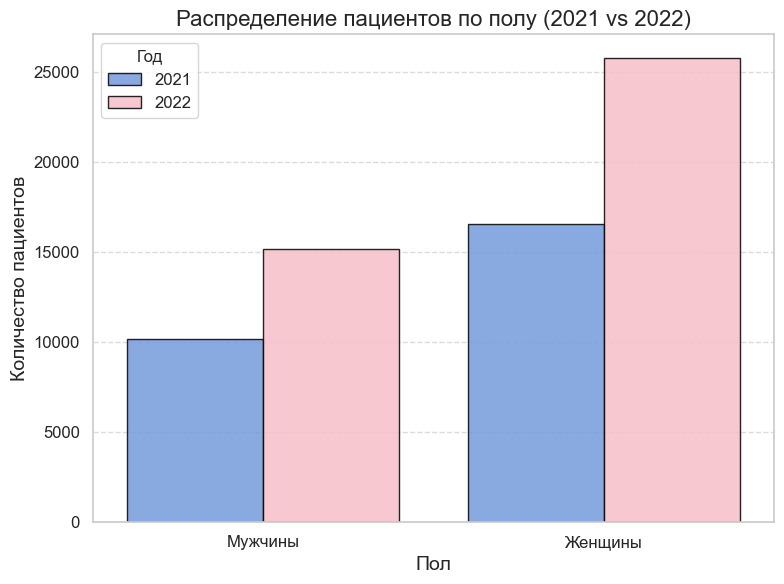

/var/folders/9d/hjcxrkbn309fh_6d5y39sdvm0000gn/T/ipykernel_9069/2902826333.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_yearly = data.groupby(["year", "age_group"]).size().reset_index(name="count")


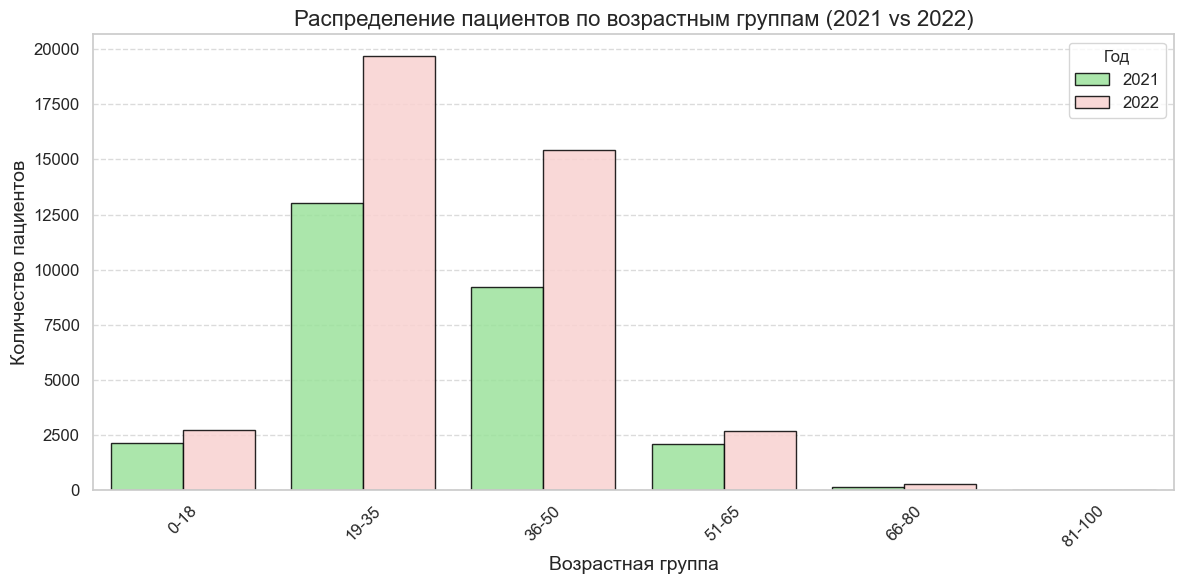

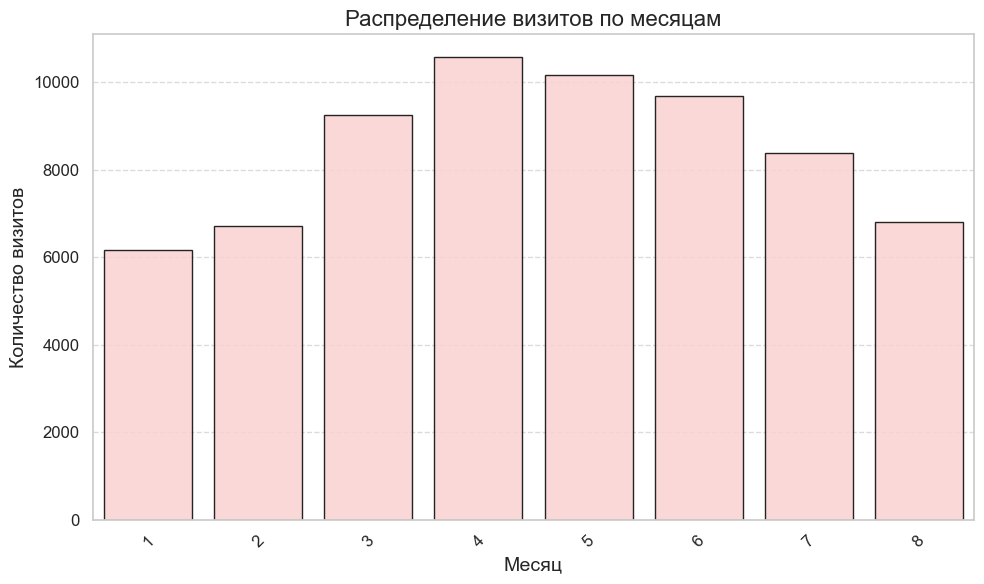

/var/folders/9d/hjcxrkbn309fh_6d5y39sdvm0000gn/T/ipykernel_9069/1958052429.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


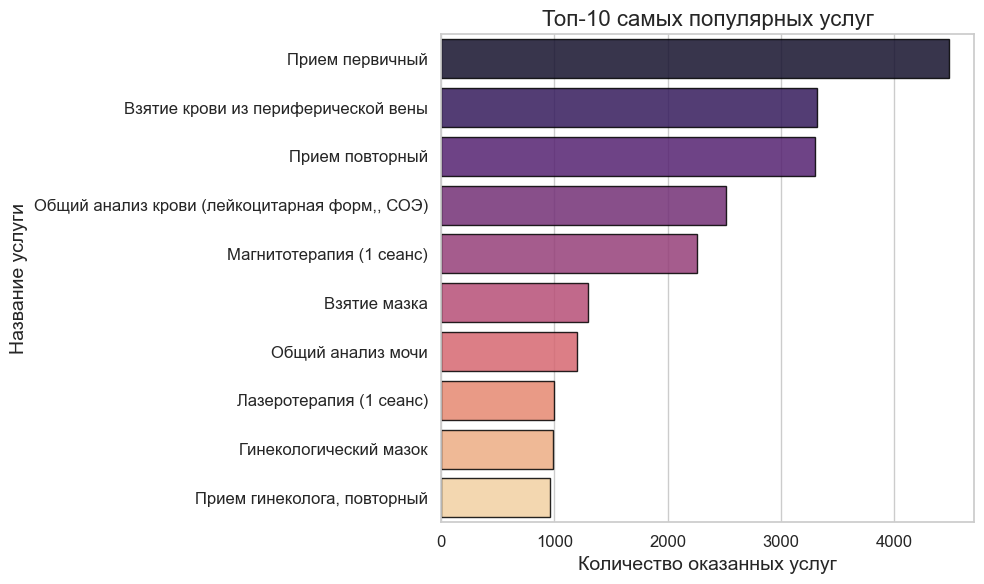

/var/folders/9d/hjcxrkbn309fh_6d5y39sdvm0000gn/T/ipykernel_9069/1245188127.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_distribution.index, y=weekday_distribution.values, palette="viridis")


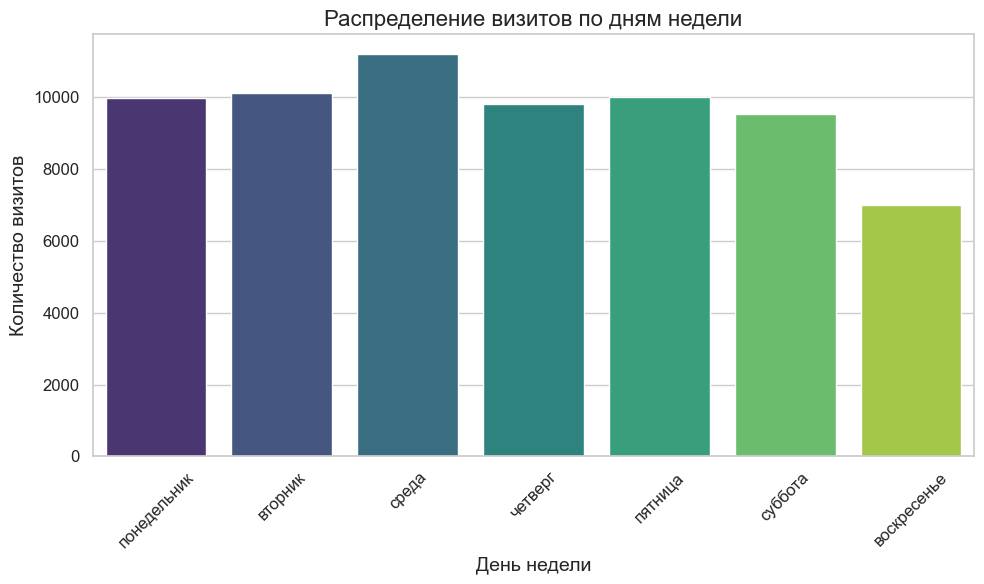

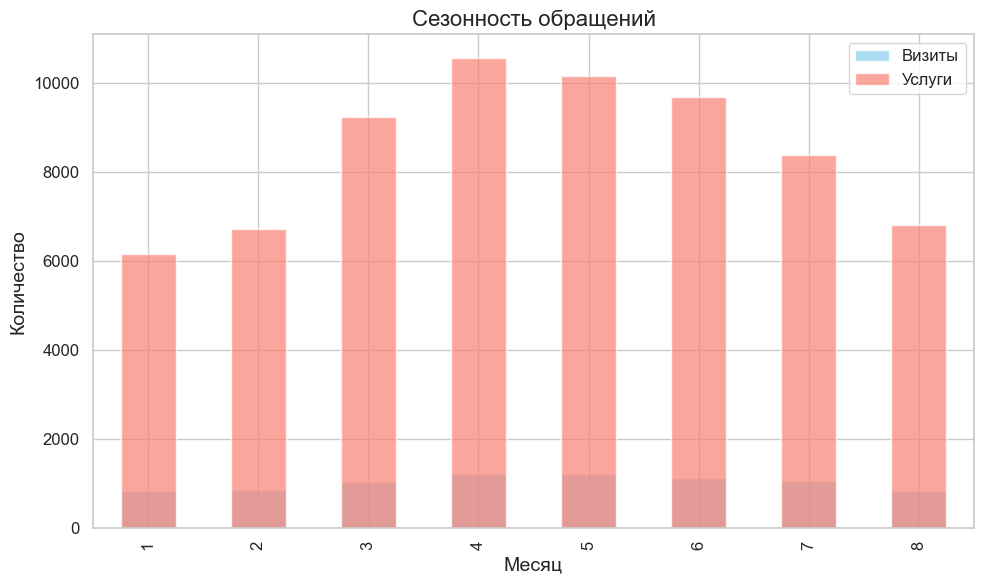

In [72]:
file_path = Path.cwd() / "data_test_task_2022.xlsx"
analyze_medical_data(file_path)

### Основные выводы

1. **Распределение по полу:**  
   - Женщины составляют большую часть пациентов, их доля значительно выросла в 2022 году.

2. **Распределение по возрасту:**  
   - Основную часть пациентов составляют группы 19-35 и 36-50 лет.  
   - Значительный рост отмечается среди пациентов 19-35 лет.

3. **Динамика визитов:**  
   - Наибольшее число визитов приходится на апрель. 
   - В 2022 году общее число визитов значительно выше, чем в 2021.

4. **Популярность услуг:**  
   - Первичный прием — самая востребованная услуга среди пациентов.

---



# Проверка гипотез


## Функции для проверки гипотез

In [53]:
# Функция для удаления выбросов 
def remove_outliers(series, multiplier=3):
    """
    Удаляет выбросы из pandas Series с использованием метода межквартильного размаха (IQR).

    Параметры:
    series (pd.Series): Данные, из которых нужно удалить выбросы.
    multiplier (float): Коэффициент для IQR, который определяет границы выбросов. По умолчанию 3.

    Возвращает:
    pd.Series: Новый объект Series без выбросов.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr
    return series[(series >= lower_bound) & (series <= upper_bound)]


In [54]:
# Hypothesis testing with a summary table of results
def hypothesis_testing(data_2021, data_2022):
    """
    Проверка гипотез о различиях между данными за 2021 и 2022 годы по нескольким параметрам.
    Для каждого параметра рассчитывается p-value и делается вывод о наличии или отсутствии статистически значимых изменений.

    Параметры:
    data_2021 (pd.DataFrame): Данные за 2021 год.
    data_2022 (pd.DataFrame): Данные за 2022 год.

    Возвращает:
    None: Выводит таблицу с результатами гипотез.
    """
    выводы = []

    # 1. Средняя стоимость услуг (с удалением выбросов)
    стоимость_2021 = remove_outliers(data_2021['service_amount'], multiplier=3)
    стоимость_2022 = remove_outliers(data_2022['service_amount'], multiplier=3)

    t_stat, p_val_ttest = ttest_ind(стоимость_2021, стоимость_2022, equal_var=False)
    результат = "Существенное изменение" if p_val_ttest < 0.05 else "Нет значимого изменения"
    гипотеза = "Средняя стоимость услуг за период изменилась."
    p_value_display = "<0.05" if p_val_ttest < 0.05 else round(p_val_ttest, 4)
    выводы.append(["Средняя стоимость услуг", гипотеза, p_value_display, результат])

    # 2. Интенсивность лечения
    интенсивность_2021 = data_2021.groupby('insured')['service_number'].sum()
    интенсивность_2022 = data_2022.groupby('insured')['service_number'].sum()

    интенсивность_2021 = remove_outliers(интенсивность_2021, multiplier=3)
    интенсивность_2022 = remove_outliers(интенсивность_2022, multiplier=3)

    t_stat, p_val_ttest = ttest_ind(интенсивность_2021, интенсивность_2022, equal_var=False)
    результат = "Существенное изменение" if p_val_ttest < 0.05 else "Нет значимого изменения"
    гипотеза = "Интенсивность лечения (среднее число услуг на пациента) изменилась."
    p_value_display = "<0.05" if p_val_ttest < 0.05 else round(p_val_ttest, 4)
    выводы.append(["Интенсивность лечения", гипотеза, p_value_display, результат])

    # 3. Распределение пациентов по полу
    пол_2021 = data_2021['sex_id'].value_counts()
    пол_2022 = data_2022['sex_id'].value_counts()
    chi2_stat, p_val_chи2, _, _ = chi2_contingency([пол_2021, пол_2022])
    результат = "Существенное изменение" if p_val_chи2 < 0.05 else "Нет значимого изменения"
    гипотеза = "Распределение пациентов по полу изменилось."
    p_value_display = "<0.05" if p_val_chи2 < 0.05 else round(p_val_chи2, 4)
    выводы.append(["Распределение по полу", гипотеза, p_value_display, результат])

    # 4. Распределение возраста пациентов
    возраст_2021 = remove_outliers(data_2021['age_for_service_date'], multiplier=3)
    возраст_2022 = remove_outliers(data_2022['age_for_service_date'], multiplier=3)

    t_stat, p_val_ttest = ttest_ind(возраст_2021, возраст_2022, equal_var=False)
    результат = "Существенное изменение" if p_val_ttest < 0.05 else "Нет значимого изменения"
    гипотеза = "Распределение пациентов по возрасту изменилось."
    p_value_display = "<0.05" if p_val_ttest < 0.05 else round(p_val_ttest, 4)
    выводы.append(["Распределение по возрасту", гипотеза, p_value_display, результат])

    # 5. Средняя стоимость лечения одного пациента за месяц
    средняя_стоимость_2021 = data_2021.groupby(['insured', data_2021['service_date'].dt.month])['service_amount'].sum().groupby('insured').mean()
    средняя_стоимость_2022 = data_2022.groupby(['insured', data_2022['service_date'].dt.month])['service_amount'].sum().groupby('insured').mean()

    t_stat, p_val_ttest = ttest_ind(средняя_стоимость_2021, средняя_стоимость_2022, equal_var=False)
    результат = "Существенное изменение" if p_val_ttest < 0.05 else "Нет значимого изменения"
    гипотеза = "Средняя стоимость лечения одного пациента за месяц изменилась."
    p_value_display = "<0.05" if p_val_ttest < 0.05 else round(p_val_ttest, 4)
    выводы.append(["Средняя стоимость лечения/мес", гипотеза, p_value_display, результат])

    # 6. Средняя стоимость одной услуги
    средняя_стоимость_услуги_2021 = data_2021['service_amount'] / data_2021['service_number']
    средняя_стоимость_услуги_2022 = data_2022['service_amount'] / data_2022['service_number']

    t_stat, p_val_ttest = ttest_ind(remove_outliers(средняя_стоимость_услуги_2021), remove_outliers(средняя_стоимость_услуги_2022), equal_var=False)
    результат = "Существенное изменение" if p_val_ttest < 0.05 else "Нет значимого изменения"
    гипотеза = "Средняя стоимость одной услуги изменилась."
    p_value_display = "<0.05" if p_val_ttest < 0.05 else round(p_val_ttest, 4)
    выводы.append(["Средняя стоимость одной услуги", гипотеза, p_value_display, результат])

    # 7. Медианная стоимость лечения одного пациента за месяц
    медианная_стоимость_2021 = data_2021.groupby(['insured', data_2021['service_date'].dt.month])['service_amount'].sum().groupby('insured').median()
    медианная_стоимость_2022 = data_2022.groupby(['insured', data_2022['service_date'].dt.month])['service_amount'].sum().groupby('insured').median()

    t_stat, p_val_ttest = ttest_ind(медианная_стоимость_2021, медианная_стоимость_2022, equal_var=False)
    результат = "Существенное изменение" if p_val_ttest < 0.05 else "Нет значимого изменения"
    гипотеза = "Медианная стоимость лечения одного пациента за месяц изменилась."
    p_value_display = "<0.05" if p_val_ttest < 0.05 else round(p_val_ttest, 4)
    выводы.append(["Медианная стоимость лечения/мес", гипотеза, p_value_display, результат])

    # 8. Процент пациентов, получивших дорогостоящие услуги
    дорогостоящие_2021 = data_2021[data_2021['service_amount'] > data_2021['service_amount'].quantile(0.9)]['insured'].nunique()
    дорогостоящие_2022 = data_2022[data_2022['service_amount'] > data_2022['service_amount'].quantile(0.9)]['insured'].nunique()

    процент_дорогостоящие_2021 = дорогостоящие_2021 / data_2021['insured'].nunique()
    процент_дорогостоящие_2022 = дорогостоящие_2022 / data_2022['insured'].nunique()

    t_stat, p_val_ttest = ttest_ind([процент_дорогостоящие_2021], [процент_дорогостоящие_2022], equal_var=False)
    результат = "Существенное изменение" if p_val_ttest < 0.05 else "Нет значимого изменения"
    гипотеза = "Процент пациентов с дорогостоящими услугами изменился."
    p_value_display = "<0.05" if p_val_ttest < 0.05 else round(p_val_ttest, 4)
    выводы.append(["Процент дорогостоящих услуг", гипотеза, p_value_display, результат])

    # Вывод таблицы
    print(tabulate(выводы, headers=["Параметр", "Гипотеза", "p-value", "Результат"], tablefmt="grid"))


In [55]:
# Путь относительно текущей рабочей директории
file_path = Path.cwd() / "data_test_task_2022.xlsx"
df = pd.read_excel(file_path)



In [56]:
# Преобразование даты в формат datetime
df['service_date'] = pd.to_datetime(df['service_date'])
df['year'] = df['service_date'].dt.year

# Разделение данных на 2021 и 2022 годы
data_2021 = df[df['year'] == 2021]
data_2022 = df[df['year'] == 2022]

# Фильтрация данных: только первые 8 месяцев каждого года
data_2021_filtered = data_2021[data_2021['service_date'].dt.month <= 8]
data_2022_filtered = data_2022[data_2022['service_date'].dt.month <= 8]





In [57]:
hypothesis_testing(data_2021_filtered, data_2022_filtered)


+---------------------------------+---------------------------------------------------------------------+-----------+-------------------------+
| Параметр                        | Гипотеза                                                            | p-value   | Результат               |
+=================================+=====================================================================+===========+=========================+
| Средняя стоимость услуг         | Средняя стоимость услуг за период изменилась.                       | <0.05     | Существенное изменение  |
+---------------------------------+---------------------------------------------------------------------+-----------+-------------------------+
| Интенсивность лечения           | Интенсивность лечения (среднее число услуг на пациента) изменилась. | 0.0656    | Нет значимого изменения |
+---------------------------------+---------------------------------------------------------------------+-----------+-------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


# **Результаты проверки гипотез**

### 1. **Средняя стоимость услуг**
- **Гипотеза:** Средняя стоимость услуг за период изменилась.  
- **Результат:** ✅ **Существенные изменения зафиксированы** *(p-value < 0.05)*.  
  Средняя стоимость услуг демонстрирует статистически значимые изменения, что может быть связано с изменением тарифов или структуры предоставляемых услуг.

### 2. **Интенсивность лечения**
- **Гипотеза:** Интенсивность лечения (среднее число услуг на пациента) изменилась.  
- **Результат:** 🚫 **Изменений не выявлено** *(p-value = 0.0656)*.  
  Наблюдается незначительная тенденция к изменению, однако она находится вне зоны статистической значимости.

### 3. **Распределение пациентов по полу**
- **Гипотеза:** Распределение пациентов по полу изменилось.  
- **Результат:** ✅ **Существенные изменения зафиксированы** *(p-value < 0.05)*.  
  Перераспределение пациентов между мужчинами и женщинами свидетельствует о возможных сдвигах в потребительском поведении или доступности услуг.

### 4. **Распределение пациентов по возрасту**
- **Гипотеза:** Распределение пациентов по возрасту изменилось.  
- **Результат:** ✅ **Существенные изменения зафиксированы** *(p-value < 0.05)*.  
  Изменение возрастной структуры пациентов может указывать на таргетирование новых возрастных групп или влияние демографических факторов.

### 5. **Средняя стоимость лечения одного пациента за месяц**
- **Гипотеза:** Средняя стоимость лечения одного пациента за месяц изменилась.  
- **Результат:** ✅ **Существенные изменения зафиксированы** *(p-value < 0.05)*.  
  Динамика средней стоимости лечения может отражать изменения в типах предоставляемых услуг или изменениях в модели потребления.

### 6. **Средняя стоимость одной услуги**
- **Гипотеза:** Средняя стоимость одной услуги изменилась.  
- **Результат:** ✅ **Существенные изменения зафиксированы** *(p-value < 0.05)*.  
  Рост или снижение средней стоимости одной услуги может быть результатом изменений в структуре ценообразования.

### 7. **Медианная стоимость лечения одного пациента за месяц**
- **Гипотеза:** Медианная стоимость лечения одного пациента за месяц изменилась.  
- **Результат:** ✅ **Существенные изменения зафиксированы** *(p-value < 0.05)*.  
  Изменение медианной стоимости указывает на сдвиг в центре распределения затрат на лечение.

### 8. **Процент пациентов с дорогостоящими услугами**
- **Гипотеза:** Процент пациентов с дорогостоящими услугами изменился.  
- **Результат:** 🚫 **Изменений не выявлено** *(p-value = nan)*.  
  Отсутствие значимых изменений может быть связано с недостатком данных или устойчивостью данного параметра.

---

# **Выводы**
- **Существенные изменения выявлены** по ключевым параметрам:  
  - Средняя и медианная стоимость лечения (за месяц и за услугу).  
  - Распределение пациентов по полу и возрасту.  
#
- **Без значимых изменений:**  
  - Интенсивность лечения (среднее число услуг на пациента).  
  - Процент пациентов, пользующихся дорогостоящими услугами .  
